## Visualizing results of the First Edition -  Original Geoparser

We have run the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to extract and resolvoe locations contained within the books of the **First Edition** of the *Encyclopaedia Britannica*, which has 832 pages.
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_first_edtion.txt nls defoe.nls.queries.geoparser_pages -r geoparser_original_EB_first_edition -n 16`

The nls_first_edition.txt has the path of this particular book that we are exploring:
`
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133901
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133902
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144133903
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850366
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850367
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850368`

The results file ( [geoparser_first_edition](http://localhost:8888/edit/results_NLS/geoparser_original_EB_first_edition)) is stored in this repository under the *results_NLS* subdirectory. 


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [37]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [18]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq)
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned')
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from all the books of the first edition
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original geotagging of the Edinburgh geoparser. 
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
    
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '56'
        - '-4'
  - lang_model: geoparser_original
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [19]:
results=read_query_results('geopaser_original_EB_first_edition')

In [20]:
df_total= geresolution_dataframe(results)

In [21]:
df_total[["Place"]].count()

Place    39523
dtype: int64

In [29]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page10,20,20,20
Page100,12,12,12
Page1000,4,4,4
Page1001,1,1,1
Page1006,2,2,2
Page1007,2,2,2
Page1009,11,11,11
Page101,44,44,44
Page1010,44,44,44


In [30]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place   Page
Latitude  Longitude              
                     37311  37311
-1.23333  121.63333      1      1
-10       -55            2      2
          -75.25         2      2
-10.51549 142.2138       2      2
-11.48333 -45.11667      2      2
-12.04318 -77.02824      1      1
-13.63389 -72.88139      1      1
-14.60485 -57.65625      6      6
-14.83333 -64.9          1      1
-17.21667 145.08333      1      1
-19.2     34.8           2      2
-20       47             2      2
-20.79094 165.24987      1      1
-20.89751 148.77115      1      1
-24.05    18.66667       2      2
-25.59971 23.40573       3      3
-25.79137 24.15809       1      1
-26.05085 27.96304       2      2
-27.80828 25.73835       6      6
-28.3907  152.9904       2      2
-29       24             5      5
-3.23846  130.14527      2      2
-3.96012  141.10789      1      1
-32.46091 121.63903      2      2
-32.91411 23.57396       2      2
-33.60097 26.71843       2      2
-33.92385 25.51566       2      2
-38.65    178            1      1
-4.575    55.44167       2      2
...                    ...    ...
6.80448   -58.15527      3      3
60        100            3      3
60.41667  24.75          1      1
61        14.5           1      1
62        10             6      6
          15            11     11
64        26             6      6
65        -18            1      1
66.01667  12.91667       1      1
67.26667  17.41667       2      2
67.75     26.5           2      2
7.1881    21.09375      38     38
7.21989   3.09084        1      1
7.23761   0.5309         1      1
7.29929   8.28984        1      1
7.83333   13.56667       2      2
8.18333   6.96667        1      1
8.75      39.88333       2      2
8.83333   33.36667       2      2
8.98234   28.29344       2      2
80.33653  53.86512       4      4
9         39.5          11     11
9.1291    6.19552        1      1
9.20839   12.48146       3      3
9.3245    166.83118     40     40
9.44111   118.44639      1      1
9.56722   39.52667       3      3
9.66028   125.52861      2      2
9.78097   7.80641        2      2
9.79029   -74.78244      8      8

[679 rows x 2 columns]

In [31]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

df_max_geolocations=df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(10)


,Latitude,Longitude,count
622,54.75844,-2.69531,54
589,52.16045,-0.70312,46
630,56,-4,41
673,9.3245,166.83118,40
400,42.83333,12.83333,40
481,46,2,38
660,7.1881,21.09375,38
89,18.16667,-77.25,36
307,40,-4,32
115,24.46861,39.61417,27


In [32]:
# Getting the geolocation details of the max frequency (50.6522111706725 	-3.615645583175173)
place_count, place_name= get_place(df_total, '54.75844', '-2.69531')
place_count, place_name

(54, 'Britain')

In [38]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Ebn']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 54 Britain
1 46 England
2 41 SCOTLAND
4 40 Italy
5 38 France
6 38 Africa
7 36 Jamaica
8 32 Spain
9 27 Medina
10 25 Paris
11 24 Edinburgh
12 24 Germany
13 23 America
14 22 Asia
15 21 Koran


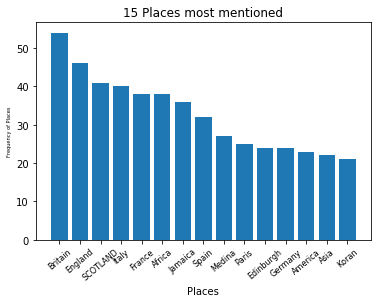

In [39]:
#Visualizing the 15 places in a Bar plot
plot_bar_places(place_label, place_freq)